In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
import cv2 as cv
#from skimage.measure import compare_ssim
from torchvision.datasets import ImageFolder
import glob
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import math
import pickle
from functools import partial
from collections import defaultdict

from PIL import Image
from glob import glob
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import cv2
import skimage.measure
import albumentations as A
from tqdm.notebook import tqdm 
#from albumentations.pytorch import ToTensor 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.video import mc3_18, r2plus1d_18

from facenet_pytorch import MTCNN



import sys
import sklearn

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt
from torchvision import models, transforms
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from torchsummary import summary
device = 'cuda' 

DATA_FOLDER = os.getcwd()

BASE_PATH = os.getcwd()

ORI_CROPS = r'D:\FF\crops\original_sequences'
MANIP_CROPS = r'D:\FF\crops\manipulated_sequences'
CROPS_FOLDER = r'D:\FF\crops'
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from glob import glob
import json
def get_videos_from_folder(folder_path):
    # List all files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if 'metadata.json' in files:
        files.remove('metadata.json')
    full_paths = [os.path.join(folder_path, f) for f in files]
    return full_paths

def get_videos_basenames_from_folder(folder_path):
    # List all files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if 'metadata.json' in files:
        files.remove('metadata.json')
    return files

def get_original_with_fakes(root_dir):
    pairs = []
    for json_path in glob(os.path.join(root_dir, "*/metadata.json")):
        with open(json_path, "r") as f:
            metadata = json.load(f)
        for k, v in metadata.items():
            original = v.get("original", None)
            if v["label"] == "FAKE":
                pairs.append((original[:-4], k[:-4] ))

    return pairs


#metadata['aaqaifqrwn.mp4']['label']

def sample_weights(metadata):
    video_fake_real_labels = metadata.iloc[0]
    class_counts = video_fake_real_labels.value_counts()
    class_weights = 1 / class_counts
    return [1/class_counts[i] for i in video_fake_real_labels] # for undersampling

In [5]:
frames_per_video = 32
mtcnn = MTCNN(margin=20, select_largest=False, factor=0.5, device=device, post_process=True) # post_process=False if want human readable image
img_size = 255 # 256 224 255
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
class ImageTransform:
    def __init__(self, size, mean, std):
        self.data_transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __call__(self, img):
        return self.data_transform(img)
transformer = ImageTransform(img_size, mean, std)

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

c:\Users\Sheryl\A

In [4]:
class EarlyStopper:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf')  # Initialize to positive infinity
        self.verbose = verbose

    def early_stop(self, val_loss, model):
        if val_loss < self.best_score:
            self.best_score = val_loss  # Update best validation loss
            self.counter = 0  # Reset patience counter
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            self.counter += 1  # Increment patience counter
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [5]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [6]:
train_dataset = ImageFolder(root=os.path.join(CROPS_FOLDER, 'train'), transform=transformer) 
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_dataset = ImageFolder(root=os.path.join(CROPS_FOLDER, 'val'), transform=transformer) 
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=64)

In [10]:
# AUC ROC curve
# classification report
# precision recall F1 score
# https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_roc_curve.html
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=48, pin_memory=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []


In [8]:
epochs = 100
model = model.to(device)
earlystopper = EarlyStopper()
# mtcnn unable to detect gan/diffusion faces
#data = data.to(device)  # Move data to GPU if available
# half precision
# A6000 at desktop\
# clustered learning
for epoch in range(epochs): 
    running_loss = 0
    correct = 0
    total = 0
    model.train()
    for data, labels in train_loader:
        data = data.squeeze(0)
        labels = labels.squeeze(0)
        labels = labels.to(device).float()
        data = data.to(device)
        optimizer.zero_grad()  # clear previous gradients

        #data = data.to(device).float()
        outputs = model(data).squeeze()
        losses = loss_fn(outputs, labels)
        running_loss += losses.item()  # accumulate loss
        
        losses.backward()
        optimizer.step()
        predicted   = (torch.sigmoid(outputs) >= 0.5).float() # calculate if label is 0 or 1
        correct += (predicted == labels).sum().item() 
        total += labels.size(0)

    average_train_loss = running_loss / total
    average_train_accuracy = correct / total
    train_loss_history.append(average_train_loss)
    train_accuracy_history.append(average_train_accuracy)

    model.eval()
    running_loss = 0
    correct = 0
    total = 0 
    for data, labels in val_loader:
        data = data.squeeze(0)
        labels = labels.squeeze(0)
        labels = labels.to(device).float()
        data = data.to(device).float()

        outputs = model(data).squeeze()
        losses = loss_fn(outputs, labels)
        running_loss += losses.item()  # accumulate loss
        predicted = (torch.sigmoid(outputs) >= 0.5).float() # calculate if label is 0 or 1
        correct += (predicted == labels).sum().item() 
        total += labels.size(0)
    average_val_loss = running_loss / total
    average_val_accuracy = correct / total
    val_loss_history.append(average_val_loss)
    val_accuracy_history.append(average_val_accuracy)

    if earlystopper.early_stop(average_val_loss, model):
        break 
    print(f"Epoch [{epoch}/{epochs}], Train Loss: {average_train_loss:.5f}, Train Accuracy: {average_train_accuracy:.5f}, Val Loss: {average_val_loss:.5f}, Val Accuracy: {average_val_accuracy:.5f}")

    
torch.save(model.state_dict(), 'model_ff.pth')

Epoch [0/100], Train Loss: 0.00111, Train Accuracy: 0.97066, Val Loss: 0.00184, Val Accuracy: 0.96125
Epoch [1/100], Train Loss: 0.00052, Train Accuracy: 0.98525, Val Loss: 0.00440, Val Accuracy: 0.90770
Epoch [2/100], Train Loss: 0.00040, Train Accuracy: 0.98733, Val Loss: 0.00143, Val Accuracy: 0.97368
Epoch [3/100], Train Loss: 0.00037, Train Accuracy: 0.98898, Val Loss: 0.00139, Val Accuracy: 0.97560
Epoch [4/100], Train Loss: 0.00036, Train Accuracy: 0.98878, Val Loss: 0.00147, Val Accuracy: 0.96554
Epoch [5/100], Train Loss: 0.00033, Train Accuracy: 0.98936, Val Loss: 0.00189, Val Accuracy: 0.96939
Epoch [6/100], Train Loss: 0.00033, Train Accuracy: 0.98983, Val Loss: 0.00223, Val Accuracy: 0.97447
Epoch [7/100], Train Loss: 0.00029, Train Accuracy: 0.99137, Val Loss: 0.00151, Val Accuracy: 0.97436
Early stopping...


Loaded pretrained weights for efficientnet-b0


C:\Users\Sheryl\AppData\Local\Temp\ipykernel_26552\1084500171.py:8: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



AUC: 0.9920


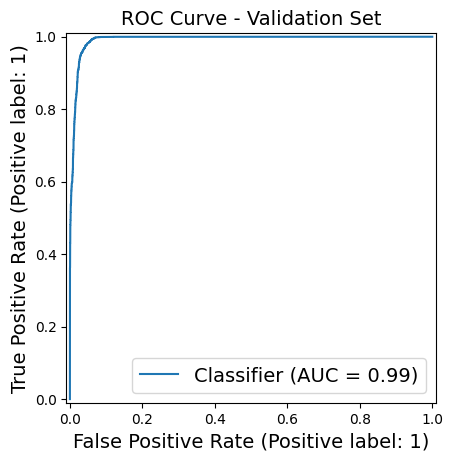

In [14]:
test_dataset = ImageFolder(root=os.path.join(CROPS_FOLDER, 'test'), transform=transformer) 
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=64)

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import RocCurveDisplay, roc_auc_score
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

val_predictions = []
val_labels = []
model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        data = data.squeeze(0)
        labels = labels.squeeze(0)
        data = data.to(device).float()

        outputs = model(data).squeeze()
        probabilities = (torch.sigmoid(outputs)) # calculate if label is 0 or 1
        val_predictions.extend(probabilities.cpu().numpy())
        val_labels.extend(labels.numpy())
# Calculate the AUC
auc_score = roc_auc_score(val_labels, val_predictions)
print(f'AUC: {auc_score:.4f}')

# Plot ROC Curve
RocCurveDisplay.from_predictions(val_labels, val_predictions)
plt.title('ROC Curve - Validation Set')
plt.show()

In [10]:
#pretrained_weights_path = 'noisy-student-efficientnet-b4.pth' # noisy student
#model = EfficientNet.from_name('efficientnet-b4')
#model.load_state_dict(torch.load(pretrained_weights_path, map_location=torch.device(device)))